In [248]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
from pathlib import Path
import flopy
import SGD
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

########
modelname = 'realdata'
########

basedir = Path(os.path.abspath('.'))
if not basedir.stem == 'DelawareSGD':
    warnings.warn('\nThis is not the expected directory. \nPlease run file from directory ".../DelawareSGD"')

model_ws = basedir.joinpath('work',modelname)
model_ws_str = model_ws.as_posix()
if not model_ws.exists():
    model_ws.mkdir()
sys.path.append(basedir.as_posix())
import config
sw_exe = config.swexe
print('Base directory:',basedir.as_posix())
print('Model workspace:',model_ws_str)

3.5.5 |Anaconda 4.2.0 (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.15.0
flopy version: 3.2.9
Base directory: E:/Projects/DelawareSGD
Model workspace: E:/Projects/DelawareSGD/work/realdata


In [249]:
#Other local functions and imports

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

In [250]:
#get real data
import pandas
datadir = basedir.joinpath('data')
fname = datadir.joinpath('seepage_flow_2015.xlsx')
flowsheet = pandas.read_excel(fname,skiprows=1)
print('Columns: ',flowsheet.columns)

Columns:  Index(['Row', 'Column', 'X', 'Y', 'Z', 'MeterNo', 'Flow', 'EC_IN', 'pctFW',
       'FlowFW', 'FlowSW'],
      dtype='object')


In [414]:
#Model grid
#Grid: 0.5 *1*1m • Size:70m*20m
        
Lx = 70.
Lz = 20.
nlay = 40
nrow = 20
ncol = 70
ocean_loc = [30,70] # location of ocean [start,end] in m from beginning of model
ocean_col = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in ocean_loc] #grid cell of ocean

xul = np.min(flowsheet.X) - 2.5
yul = np.max(flowsheet.Y) - ocean_loc[0] - 13.5
rotation = 90
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = Lz
henry_botm = np.linspace(henry_top - delv, 0., nlay)

#Period data
perlen = [1,100]
nstp = [100,100]
nper = len(perlen)
steady = [True,False]
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1
ssm_data = None
verbose = True

In [415]:
#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws.as_posix(),verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,rotation=rotation, xul=xul, yul=yul)

realdata.nam
adding Package:  DIS


In [416]:
#Hydraulic conductivity field 
hkSand = 80.  #horizontal hydraulic conductivity m/day
hkClay = 1. 
lithmat = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32) #sandy background
addclay_yn = 1


def rand_clay_blocks(lithmat,hkClay,numblocks,sizeblocks):
    nlay,nrow,ncol = lithmat.shape
    lay_block = np.random.randint(1,nlay-sizeblocks[0],numblocks)
    row_block = np.random.randint(0,nrow-sizeblocks[1]+1,numblocks)
    col_block = np.random.randint(1,ncol-sizeblocks[2],numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i],lay_block[i]+sizeblocks[0]),
                        slice(row_block[i],row_block[i]+sizeblocks[1]),
                        slice(col_block[i],col_block[i]+sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks

#add low conductivity regions
if addclay_yn == 1:
    lithmat = rand_clay_blocks(lithmat,hkClay,100,(2,2,5))
low_k_loc = (20,30)
low_k_col = loc_to_col(low_k_loc)
#lithmat[1:3,0,0:65] = hkClay

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [417]:
#Set Hydraulic properties

hk = lithmat
sy = 0.15
ss = 0.00005
por = 0.2
vka = 1/10 # = vk/hk
al = 3 #longitudinal dispersivity, in m
#dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem
dmcoef = 0. #test for numerical dispersion

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)

In [418]:
#BCs
calc_inland_head = 1 #don't calculate from hgrad
manual_inland_head = Lz + .1
ocean_shead = [Lz,Lz-.5]
ocean_ehead = ocean_shead
start_fresh_yn = 1

# save cell fluxes to unit 53
ipakcb = 53

#MODFLOW BCs
hgrad = 0.0033 #hydraulic gradient, m/m
qinflow = 0  #influent FW m3/day

#Create ocean boundary at top of model
ocean_loc = [30,70] # location of ocean [start,end] in m
ocean_col = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in ocean_loc]
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1
m.ocean_arr = ocean_bool
if calc_inland_head ==1:
    head_inland = ocean_loc[0]*hgrad + Lz
else:
    head_inland = manual_inland_head


#Set ibound
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1 #first column (FW boundary) has fixed head
ibound[ocean_bool] = -1
ibound[0:2,:,ocean_col[0]-3:ocean_col[0]] = 0

#Set starting heads
strt = head_inland*np.ones((nlay, nrow, ncol)) #starting heads (for fixed head BC, this is will assign the head)
strt[ocean_bool] = ocean_shead[0] #head of ocean boundary

#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated

sconc[ocean_bool] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
icbund[(ibound < 0)] = -1 #constant concentration cells where also constant head

#Constant head boundary
stress_period_data = {}
ocean_sub = np.where(ocean_bool)
for i in range(nper):
    dat = []
    for j in range(np.sum(ocean_bool)):
        dat.append([ocean_sub[0][j],ocean_sub[1][j],ocean_sub[2][j],ocean_shead[i],ocean_ehead[i]])
    stress_period_data[i] = dat

In [419]:
#Create instances in flopy

bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb, ss=ss, sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)
#wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         #nlay=nlay, nrow=nrow, ncol=ncol, nper=nper, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                         sconc=sconc, nprs=-10)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)
chd = flopy.modflow.ModflowChd(m, stress_period_data=stress_period_data)
#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


adding Package:  BAS6
Adding realdata.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  PCG
Adding realdata.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
adding Package:  SSM
adding Package:  CHD
adding Package:  VDF


In [455]:
#y : list of cell y-centroids
#x : list of cell x-centroids
#z : array of floats (nlay, nrow, ncol)
x,y,z = dis.get_node_coordinates()
y = y + yul
x = xul + x
xpos = flowsheet.X
ypos = flowsheet.Y
xnode = []
ynode = []
for i in range(xpos.size):
    xnode.append([j for j in range(x.size) if np.abs(xpos[i]-x[j])<=delr/2][-1])
    ynode.append([j for j in range(y.size) if np.abs(ypos[i]-y[j])<=delc/2][-1])
xnode = np.asarray(xnode).astype(int)
ynode = np.asarray(ynode).astype(int)

X:  (488928.0, 488948.0)
Y:  (4271431.9, 4271501.9)


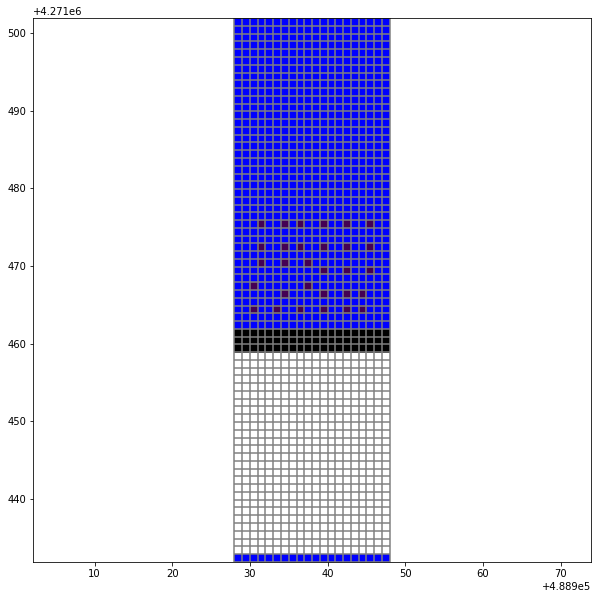

In [456]:
f = plt.figure(figsize=(10,10))
plt.clf()
ax = f.add_subplot(1, 1, 1)
mm = flopy.plot.ModelMap(ax=ax,model=m,dis=m.dis)
a = np.zeros((nlay,nrow,ncol))
a[0,xnode,ynode]=1
am = np.ma.masked_array(a,mask=a==0)
linecollection = mm.plot_grid();
patchcollection = mm.plot_ibound();
print('X: ',linecollection.axes.get_xbound())
print('Y: ',linecollection.axes.get_ybound())
mm.plot_array(am)
ax.set_aspect('equal', 'datalim')

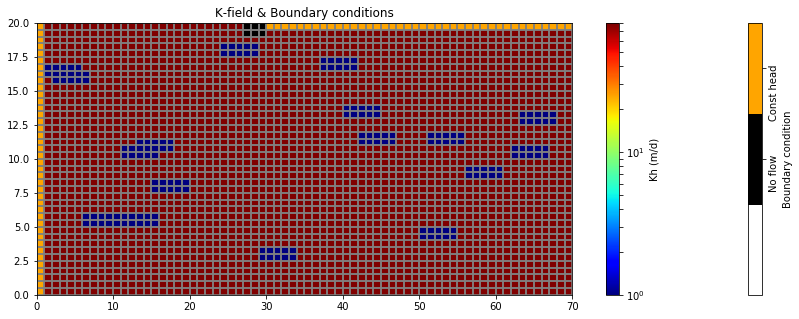

In [425]:
m.plot_hk_ibound(rowslice=2)

In [463]:
obs_tup = (flowsheet.Flow.as_matrix(),np.zeros(xnode.size,dtype=int),xnode,ynode)
self = m
def write_obs(self,obs_array,suffix='.obs'):
        fname = 'flux' + suffix
        fout= open(os.path.join(self.model_ws,fname),"w")
        fout.write('Values are zero-based \n')
        fout.write('{:14s} {:4s} {:4s} {:4s} \n'.format("flux", "lay","row", "col"))
        for i in range(len(obs_tup[0])):
            fout.write('{:14.4e} {:4d} {:4d} {:4d}\n'
                       .format(obs_tup[0][i],obs_tup[1][i],obs_tup[2][i],obs_tup[3][i]))
        fout.close()
        print('output FILE WRITTEN: ' + os.path.join(self.model_ws.as_posix(), fname))

    
write_obs(self,obs_array)
    

AttributeError: 'str' object has no attribute 'as_posix'

In [461]:
(flowsheet.Flow.as_matrix(),np.zeros(xnode.size,dtype=int),xnode,ynode)

(array([ 6.27018323, 23.50838634, 47.73658573, 63.1256284 , 33.11499485,
        24.23926464, 32.38351468, 44.97284409, 39.49768024, 29.91957486,
        57.63760348, 58.34845761,  9.63760818, 12.48785055, 55.30033077,
        55.60079229, 84.8112371 , 21.37092561, 20.37218306, 11.59154953,
        20.1004071 , 25.17694793, 15.85957314, 11.81000004, 17.53001643,
        39.52848555, 26.30738153,  7.76560905,  9.23813193,  8.60400683]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 array([16, 14, 11,  8,  5,  2, 16, 14, 11,  9,  6,  2, 17, 14, 11,  9,  6,
         3, 17, 14, 11,  8,  6,  3, 17, 14, 11,  8,  6,  3]),
 array([32, 32, 32, 32, 32, 32, 34, 34, 34, 35, 34, 35, 37, 37, 37, 38, 38,
        38, 40, 40, 40, 40, 40, 40, 43, 43, 43, 43, 43, 43]))

In [445]:
xnode

array([16, 14, 11,  8,  5,  2, 16, 14, 11,  9,  6,  2, 17, 14, 11,  9,  6,
        3, 17, 14, 11,  8,  6,  3, 17, 14, 11,  8,  6,  3])